In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# PORT-CALLS

### Сущность данных
Port call –  операция в морской логистике, когда судно останавливается в определенном порту для выполнения различных необходимых действий, таких как погрузка или разгрузка груза, заправка топливом, смена экипажа и ремонт. Этот процесс включает в себя несколько этапов, в том числе прибытие, швартовку, грузовые операции и отбытие. В нашем случае доступны только данные по **прибытиям и отбытиям**

### Источник
API [myshiptracking.com](myshiptracking.com)

[Документация](https://api.myshiptracking.com/docs/port-calls)

Сотрудники сайта любезно дали мне бесплатные кредиты на использование их API специально для выполнения целей исследования

### Описание полей
- event – тип события (ARRIVAL/DEPARTURE)
- time_utc & time_local – таймстамп события
- mmsi & imo – идентификаторы судна
- vessel_name – название судна
- port_id & unloco – идентификаторы порта
- port_name – название порта

### Временной период
Данные доступны за весь 2024 


### *Вспомогательные данные
Отдельно собранная таблица с характеристиками судов, поля:
- vessel_name – название судна
- mmsi & imo – идентификатор судна 
- vessel_type – тип судна
- flag – флаг страны судна
- area – последняя зона нахождения судна

In [57]:
port_calls = pd.read_csv("../data/port_calls.csv")
port_calls['time_utc'] = pd.to_datetime(port_calls['time_utc'])
port_calls['time_local'] = pd.to_datetime(port_calls['time_utc'])
port_calls.head()

,event,time_utc,time_local,mmsi,imo,vessel_name,port_id,port_name,unloco
0,ARRIVAL,2024-01-30 13:07:53+00:00,2024-01-30 13:07:53+00:00,253198000,NaN,AVISOA,6985,TOAMASINA,MGTOA
1,DEPARTURE,2024-01-30 10:51:18+00:00,2024-01-30 10:51:18+00:00,355280000,9747120.0,NORD OCEANIA,6985,TOAMASINA,MGTOA
2,DEPARTURE,2024-01-29 04:26:42+00:00,2024-01-29 04:26:42+00:00,354858000,9478793.0,KOUROS GLORY,6985,TOAMASINA,MGTOA
3,ARRIVAL,2024-01-29 02:22:21+00:00,2024-01-29 02:22:21+00:00,355280000,9747120.0,NORD OCEANIA,6985,TOAMASINA,MGTOA
4,DEPARTURE,2024-01-28 11:33:30+00:00,2024-01-28 11:33:30+00:00,565795000,9356830.0,KOTA NABIL,6985,TOAMASINA,MGTOA


In [58]:
print(f"Записей: {port_calls.shape[0]}")
print(f"Уникальных портов: {len(port_calls.port_name.unique())}")
print(f"Уникальных кораблей: {len(port_calls.mmsi.unique())}")

Записей: 143203
Уникальных портов: 28
Уникальных кораблей: 8741


In [59]:
port_calls.event.value_counts()

event
DEPARTURE    72027
ARRIVAL      71176
Name: count, dtype: int64

In [60]:
files = ["vessels_8.csv", "vessels_86.csv"]

dataframes = [pd.read_csv(os.path.join("../data/vessels", file)) for file in files]
vessels = pd.concat(dataframes, ignore_index=True)

vessels = vessels[['mmsi', 'vessel_type',
                   'ais_type', 'size_a', 'size_b', 'size_c', 'size_d', 'flag',
                   'gt', 'dwt', 'built', 'avg_sog', 'max_sog']]
vessels.head()

,mmsi,vessel_type,ais_type,size_a,size_b,size_c,size_d,flag,gt,dwt,built,avg_sog,max_sog
0,253198000,Tanker,80.0,96.0,23.0,16.0,1.0,LU,NaN,NaN,NaN,10.9,13.2
1,355280000,Tanker,80.0,145.0,36.0,21.0,11.0,PA,NaN,NaN,NaN,NaN,NaN
2,354858000,Bulk Carrier,70.0,162.0,28.0,19.0,13.0,PA,31246.0,55654.0,2011.0,NaN,NaN
3,565795000,Container Ship,70.0,139.0,40.0,22.0,6.0,SG,20902.0,26000.0,2008.0,12.5,16.6
4,477111700,Container Ship,70.0,193.0,16.0,6.0,24.0,HK,26404.0,34194.0,2008.0,16.0,19.9


In [61]:
port_calls = port_calls.merge(vessels, on='mmsi', how='left')

In [62]:
port_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144690 entries, 0 to 144689
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   event        144690 non-null  object             
 1   time_utc     144690 non-null  datetime64[ns, UTC]
 2   time_local   144690 non-null  datetime64[ns, UTC]
 3   mmsi         144690 non-null  int64              
 4   imo          94911 non-null   float64            
 5   vessel_name  143313 non-null  object             
 6   port_id      144690 non-null  int64              
 7   port_name    144690 non-null  object             
 8   unloco       144690 non-null  object             
 9   vessel_type  144555 non-null  object             
 10  ais_type     144559 non-null  float64            
 11  size_a       144554 non-null  float64            
 12  size_b       144554 non-null  float64            
 13  size_c       144554 non-null  float64            
 14  size

In [63]:
port_calls.to_csv("../data/proc_port_calls.csv", index=False)

Много пропусков в IMO, будем использовать mmsi. У каких-то кораблей нет названия – дропнуть? Думаю, необязательно

In [50]:
port_calls.drop(columns=['imo'], inplace=True)   
# port_calls.dropna(subset=['port_name', 'mmsi'], inplace=True)

In [51]:
port_calls.mmsi.value_counts()

mmsi
634122000    3740
634123000    3676
375492000    2688
376913000    2108
375106000    1896
             ... 
210885000       1
630001135       1
352001455       1
477632400       1
312562000       1
Name: count, Length: 8741, dtype: int64

Немало кораблей, которые очень часто делают port calls. Скорее всего, это пассажирские судна. Стоит ли их оставлять?

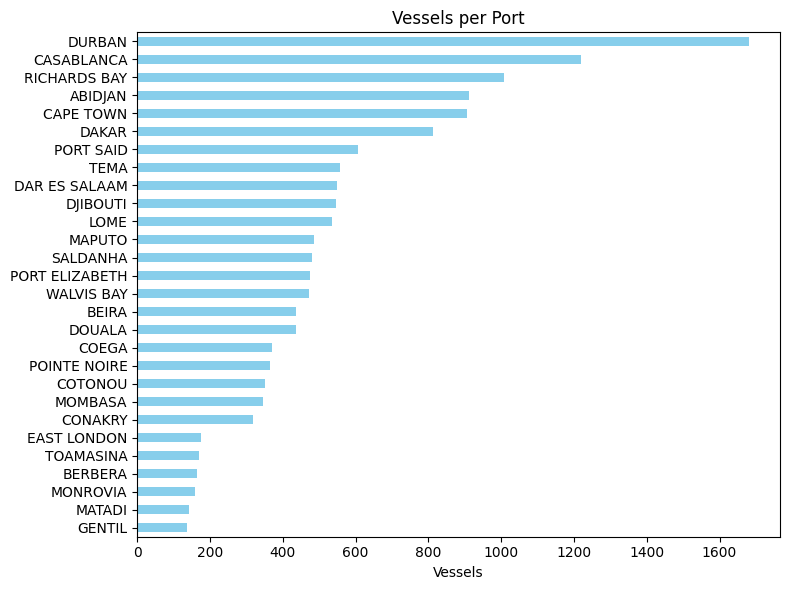

In [52]:
vessels_per_port = port_calls.groupby('port_name')['mmsi'].nunique()
vessels_per_port = vessels_per_port.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
vessels_per_port.plot(kind='barh', color='skyblue')
plt.title('Vessels per Port')
plt.xlabel('Vessels')
plt.ylabel('')
plt.tight_layout()
plt.show()

Распределение не выглядит слишком смещенным. Самый загруженный порт – Durban (South Africa). Из топ-5 портов 3 принадлежат ЮАР

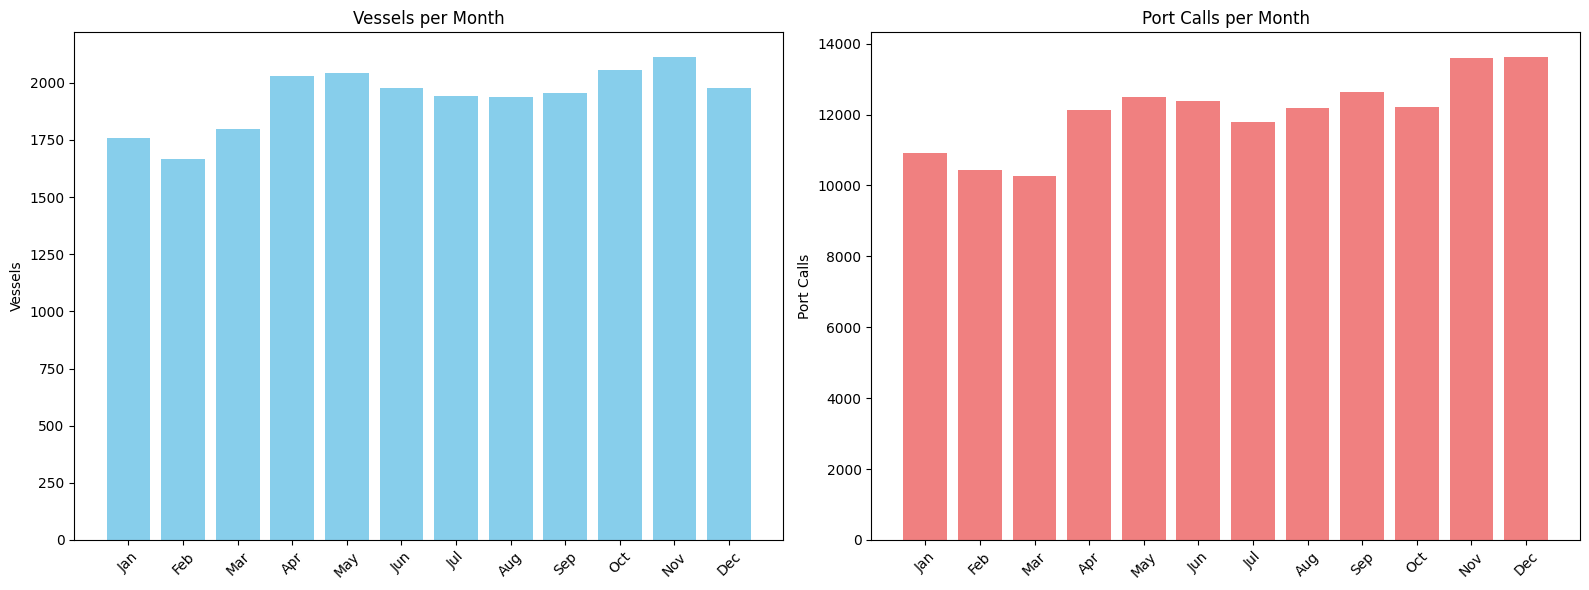

In [53]:
port_calls['month'] = port_calls['time_utc'].dt.month
vessels_per_month = port_calls.groupby('month')['mmsi'].nunique()
port_calls_per_month = port_calls.groupby('month').size()
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)


axes[0].bar(vessels_per_month.index, vessels_per_month.values, color='skyblue')
axes[0].set_title('Vessels per Month')
axes[0].set_xlabel('')
axes[0].set_ylabel('Vessels')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)

axes[1].bar(port_calls_per_month.index, port_calls_per_month.values, color='lightcoral')
axes[1].set_title('Port Calls per Month')
axes[1].set_xlabel('')
axes[1].set_ylabel('Port Calls')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], rotation=45)

plt.tight_layout()
plt.show()

Распределение кораблей и port calls по месяцам равномерное.

In [54]:
port_calls.vessel_type.value_counts()

vessel_type
Tug                     27248
Passenger               19598
Container Ship          13674
Cargo                   10404
Not available            9729
                        ...  
Ore/Oil Carrier             2
Replenishment Vessel        1
Fish Factory                1
Pipe Layer                  1
Pilot Ship                  1
Name: count, Length: 102, dtype: int64

In [55]:
port_calls.flag.value_counts()

flag
ZA    20217
VC    15671
PA    11899
LR     9820
KE     8984
      ...  
AO        1
OM        1
SV        1
GM        1
AZ        1
Name: count, Length: 121, dtype: int64

# COMMODITY PRICES


### Сущность данных
Shanghai Futures Exchange (SHFE) – крупнейшая биржа Китая. Данные представляют собой ключевые агрегированные по неделям показатели для различных фьючерсов (металлы, энергия, химия).

### Источник
[Сайт SHFE](https://tsite.shfe.com.cn/eng/reports/statistical/weekly/)



### Описание полей
- Species – код фьючерса. Например: cu2507 – фьючерс на медь
- Weekly Opening Price
- High
- Low
- Weekly Close
- Net Change –
- Open Interest –
- O.I Change –
- Weekly Volume –
- Volume –
- Turnover –
- Week Start –
- Week End –

### Система счисления
- RMB yuan/ton for Copper, Aluminum, Zinc, Nickel, Tin, Aluminium Oxide, Rebar, Wire-rod, Hot rolled coils, Lead, Natural Rubber, Fuel Oil, Bitumen, Woodpulp, Stainless Steel, Butadiene Rubber.
- RMB yuan/g for Gold. RMB yuan/ kg for Sliver. RMB yuan/barrel for Crude Oil.
- RMB yuan/ton for LSFO, TSR 20 and Copper(BC)

### Временной период
Данные доступны за 2023-2024

Гранулярность – неделя

In [33]:
comm = pd.read_csv('/Users/dushamishkin/VSCProjects/BRI-thesis/data/commodities_cleaned.csv')

comm = comm.drop(columns=['Extra_Column_13'])
comm['Week Start'] = pd.to_datetime(comm['Week Start'])
comm['Week End'] = pd.to_datetime(comm['Week End'])

In [34]:
comm.columns.tolist()

['Species',
 'Weekly Opening Price',
 'High',
 'Low',
 'Weekly Close',
 'Net Change',
 'Open Interest',
 'O.I Change',
 'Weekly Volume',
 'Volume',
 'Turnover',
 'Week Start',
 'Week End']

In [26]:
comm.head()

,Species,Weekly Opening Price,High,Low,Weekly Close,Net Change,Open Interest,O.I Change,Weekly Volume,Volume,Turnover,Week Start,Week End
0,cu2406,80020.0,80380.0,79410.0,79580.0,-1620.0,30940,-4310,79750.0,16930.0,675123.80,2024-06-10,2024-06-16
1,cu2407,80620.0,80680.0,79600.0,79870.0,-1660.0,173378,-3452,80090.0,91327.0,3657570.66,2024-06-10,2024-06-16
2,cu2408,80330.0,80890.0,79780.0,80070.0,-1650.0,147488,-1723,80310.0,60556.0,2431780.53,2024-06-10,2024-06-16
3,cu2409,80700.0,81020.0,79900.0,80180.0,-1600.0,93078,-891,80420.0,43176.0,1736189.14,2024-06-10,2024-06-16
4,cu2410,80760.0,81130.0,80020.0,80290.0,-1590.0,38283,-99,80550.0,10716.0,431602.87,2024-06-10,2024-06-16


In [ ]:
print(f"Записей: {comm.shape[0]}")
print(f"Уникальных фьючерсов: {len(comm['Species'].unique())}")
print(f"Недель: {len(comm['Week Start'].unique())}")

Записей: 22707
Уникальных фьючерсов: 759
Недель: 99


In [ ]:
comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22707 entries, 0 to 22706
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Species               22707 non-null  object        
 1   Weekly Opening Price  22707 non-null  float64       
 2   High                  22707 non-null  float64       
 3   Low                   22707 non-null  float64       
 4   Weekly Close          22707 non-null  float64       
 5   Net Change            22707 non-null  float64       
 6   Open Interest         22707 non-null  int64         
 7   O.I Change            22707 non-null  int64         
 8   Weekly Volume         22707 non-null  float64       
 9   Volume                22707 non-null  float64       
 10  Turnover              22707 non-null  float64       
 11  Week Start            22707 non-null  datetime64[ns]
 12  Week End              22707 non-null  datetime64[ns]
dtypes: datetime64[ns

In [30]:
comm.describe()

,Weekly Opening Price,High,Low,Weekly Close,Net Change,Open Interest,O.I Change,Weekly Volume,Volume,Turnover,Week Start,Week End
count,22707.000000,22707.000000,22707.000000,22707.000000,22707.000000,2.270700e+04,22707.000000,22707.000000,2.270700e+04,2.270700e+04,22707,22707
mean,30938.948110,31215.618594,30598.763057,30889.538521,15.643622,4.157920e+04,70.348395,30900.868466,5.025254e+04,5.036330e+05,2024-01-15 13:24:22.544590080,2024-01-21 13:24:22.544590080
min,408.600000,411.040000,408.260000,410.340000,-15000.000000,0.000000e+00,-661916.000000,410.080000,1.000000e+00,3.100000e+00,2023-01-02 00:00:00,2023-01-08 00:00:00
25%,3639.000000,3669.000000,3605.000000,3634.000000,-75.000000,3.000000e+02,-16.000000,3638.000000,4.000000e+01,3.618450e+02,2023-07-17 00:00:00,2023-07-23 00:00:00
50%,7583.000000,7678.000000,7461.000000,7596.000000,-3.440000,3.181000e+03,3.000000,7565.000000,7.420000e+02,7.102260e+03,2024-01-29 00:00:00,2024-02-04 00:00:00
75%,19050.000000,19157.500000,18875.000000,19030.000000,50.000000,2.468000e+04,201.000000,19002.500000,1.643750e+04,1.675416e+05,2024-07-15 00:00:00,2024-07-21 00:00:00
max,285280.000000,294460.000000,285050.000000,287200.000000,229700.000000,2.344611e+06,380096.000000,290670.000000,1.161724e+07,7.957663e+07,2024-12-23 00:00:00,2024-12-29 00:00:00
std,57337.092511,57904.676529,56628.827245,57221.456873,2967.914987,1.489497e+05,10816.345033,57252.472672,2.455583e+05,2.155992e+06,NaN,NaN


In [37]:
comm['Species'].value_counts()

Species
bu2412                            96
bu2503                            85
bu2409                            83
bu2506                            76
sc2412                            74
                                  ..
wr2402                             1
wr2507                             1
wr2504                             1
wr2412                             1
wr2312                             1
Name: count, Length: 759, dtype: int64

Возможно, фьючерсы с маленьким числом записей придется дропнуть

# News


### Сущность данных
Тексты статей на китайском языке, спаршенные с известного китайского новостного ресурса Yicai. Статьи были взяты из раздела "Финансы". 

### Источник
[Yicai Finance News](https://www.yicai.com/news/jinrong/)

### Поля
- datetime
- title
- text

### Временной период
Данные доступны за 2023-2024

Гранулярность – день

In [5]:
files = ["2022-12-14.csv", "2023-12-01.csv", "2024-12-19.csv"]

dataframes = [pd.read_csv(os.path.join("../data/news", file)) for file in files]
news = pd.concat(dataframes, ignore_index=True)

In [6]:
news = news[news['datetime'].str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$', na=False)]
news['datetime'] = pd.to_datetime(news['datetime'])

news = news.drop_duplicates(subset=['text', 'title'])
news.dropna(inplace=True)
news = news[news.datetime >= '2023-01-01']

news['text_length'] = news['text'].str.len()


news.head()

,title,datetime,text,text_length
0,央行：11月对金融机构开展常备借贷便利操作共48.71亿元,2023-12-01 16:29:00,12月1日，央行公布2023年11月常备借贷便利开展情况。为满足金融机构临时性流动性需求，2...,211
1,汇正财经荣获第六届社会责任大会“年度最有温度金融公司”称号,2023-12-01 15:43:00,2023年11月29日，第六届社会责任大会暨“2023奥纳奖颁奖典礼”在北京召开。凭借多年来...,1450
2,近期密集出台金融政策，一文速览！,2023-12-01 15:21:00,中央金融工作会议强调，要加快建设金融强国，全面加强金融监管，完善金融体制，优化金融服务，防范...,3292
3,波士顿董事总经理、全球合伙人谭彦：数字化转型带来银行业全方位、体系性变革,2023-12-01 10:27:00,数字经济时代，新技术浪潮正在深刻改变银行业的运营模式和服务方式，同时也为银行业融入“数字中国...,1946
4,工行：近期与多家重点房企对接交流，主要采取一对一等形式,2023-12-01 09:58:00,近日，浙商银行、建设银行、交通银行等多家银行（拟）召开房企座谈会，市场对于新一轮房企融资支持...,726


In [78]:
print(f"Статей: {news.shape[0]}")

Статей: 4483


In [79]:
news['month'] = news['datetime'].dt.to_period('M')

articles_per_month = news.groupby('month').size()

avg_articles_per_month = articles_per_month.mean()

print(f"Среднее число статей в месяц: {avg_articles_per_month:.2f}")
print(f"Среднее количество слов в статье: {news.text_length.mean():.2f}")

Среднее число статей в месяц: 186.79
Среднее количество слов в статье: 1943.24


# News (old)


### Сущность данных
Тексты статей на английском, французском и арабском языках, взятые с помощью специального API Media Stack. Изначально запрашивал категории general + finance, но получил статьи только по general.

### Источник
[Media Stack (historical news API)](https://mediastack.com/documentation)

### Поля
- author
- title
- description
- url
- source
- category
- language
- country
- published_at

### Временной период
Данные доступны за 2023-2024

Гранулярность – день

In [3]:
files = ["news_2023.csv", "news_2024.csv"]

dataframes = [pd.read_csv(os.path.join("../data/news_old", file)) for file in files]
news_old = pd.concat(dataframes, ignore_index=True)

news_old = news_old.drop(columns=['image'])
# news_old['published_at'] = pd.to_datetime(news_old['published_at']).dt.strftime('%Y-%m-%d %H-%M')
news_old = news_old.drop_duplicates().dropna()

news_old['desc_length'] = news_old['description'].str.len()

In [4]:
news_old.head()

,author,title,description,url,source,category,language,country,published_at,desc_length
0,"Patricia Fersch, Contributor",Can I Reduce My Child Support Payments Because...,In addition to the emotional impact of being l...,https://www.forbes.com/sites/patriciafersch/20...,Leadership,general,en,ng,2023-01-31T23:34:51+00:00,265
1,"Elizabeth Freedman, Contributor",Why CEOs Must Lead With Inspiration In 2023,Out of everything CEOs and senior leaders coul...,https://www.forbes.com/sites/elizabethfreedman...,Leadership,general,en,ng,2023-01-31T23:23:17+00:00,298
2,"Peter High, Contributor",Wendy’s CIO Kevin Vasconi Rethinks Customer Ex...,"Kevin Vasconi has been a digital trailblazer, ...",https://www.forbes.com/sites/peterhigh/2023/01...,Leadership,general,en,ng,2023-01-31T23:22:06+00:00,237
3,"Zenger News, Contributor",Three Things Leaders Should Know About A Europ...,Belarusian President Alexander Lukashenko arri...,https://www.forbes.com/sites/zengernews/2023/0...,Leadership,general,en,ng,2023-01-31T23:07:23+00:00,167
4,"Kenneth J. Williams Jr., Contributor",Trevor Noah On What He’s Most Excited About Fo...,It’s a monumental moment for the world of musi...,https://www.forbes.com/sites/kennethjwilliamsj...,Leadership,general,en,ng,2023-01-31T22:39:00+00:00,122


In [108]:
news_old['datetime'] = pd.to_datetime(news_old['published_at'], errors='coerce')
news_old['month'] = news_old['datetime'].dt.to_period('M')

articles_per_month = news_old.groupby('month').size()

news_old['text_length'] = news_old['description'].str.len()

avg_articles_per_month = articles_per_month.mean()
avg_chars_per_article = news_old['text_length'].mean()

print(f"Среднее число статей в месяц: {avg_articles_per_month:.2f}")
print(f"Среднее количество символов в статье: {avg_chars_per_article:.2f}")

Среднее число статей в месяц: 4436.25
Среднее количество символов в статье: 422.49


/var/folders/0w/y2wjb705539ckxrjgz4jqckc0000gn/T/ipykernel_3660/1638759797.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  news_old['month'] = news_old['datetime'].dt.to_period('M')


In [109]:
news_old.country.value_counts()

country
ng    71038
za    22847
ma    10933
cn      958
hk      519
eg      175
Name: count, dtype: int64

In [110]:
news_old.language.value_counts()

language
en    95362
fr    10931
ar      177
Name: count, dtype: int64

Вообще нет китайского языка :(

In [111]:
news_old.category.value_counts()

category
general    106470
Name: count, dtype: int64

По какой-то причине спарсились только статьи по категории general (должна быть еще категория finance)